## Install Fenics

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2022-01-13 11:03:12--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2064 (2.0K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.02K  --.-KB/s    in 0s      

2022-01-13 11:03:12 (33.8 MB/s) - ‘/tmp/fenics-install.sh’ saved [2064/2064]

+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e270331/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e270331/releases/pybind11-install.sh == http* ]]
+ wget https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e270331/releases/pybind11-install.sh -O /tmp/pybind11-install.sh
--2022-01-13 11:03:12--  https://github.com/fem-on-

## Cahn-Hilliard Problem


In [ ]:
import random
from dolfin import *

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        values[0] = 0.63 + 0.02*(0.5 - random.random())
        values[1] = 0.0
    def value_shape(self):
        return (2,)

# Class for interfacing with the Newton solver
class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

# Model parameters
lmbda  = 1.0e-02  # surface parameter
dt     = 5.0e-06  # time step
theta  = 0.5      # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(96, 96, CellType.Type.triangle)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)
# Define trial and test functions
du    = TrialFunction(ME)
q, v  = TestFunctions(ME)

# Define functions
u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc, dmu = split(du)
c,  mu  = split(u)
c0, mu0 = split(u0)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
u.interpolate(u_init)
u0.interpolate(u_init)

# Compute the chemical potential df/dc
c = variable(c)
f    = 100*c**2*(1-c)**2
dfdc = diff(f, c)

# mu_(n+theta)
mu_mid = (1.0-theta)*mu0 + theta*mu

# Weak statement of the equations
L0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx
L1 = mu*v*dx - dfdc*v*dx - lmbda*dot(grad(c), grad(v))*dx
L = L0 + L1

# Compute directional derivative about u in the direction of du (Jacobian)
a = derivative(L, u, du)

# Create nonlinear problem and Newton solver
problem = CahnHilliardEquation(a, L)
solver = NewtonSolver()
solver.parameters["linear_solver"] = "lu"
solver.parameters["convergence_criterion"] = "incremental"
solver.parameters["relative_tolerance"] = 1e-6

# Output file
file_results = XDMFFile("./cahn-hilliard/ch-solution_2d.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

def save_to_file(uu, t):
    _c, _mu = uu.split()
    _c.rename("c", "concentration")
    _mu.rename("mu", "chemical potential")
    file_results.write(_c, t)
    file_results.write(_mu, t)

# Step in time
t = 0.0
T = 0.0025
save_to_file(u,t)
while (t < T):
    t += dt
    u0.vector()[:] = u.vector()
    solver.solve(problem, u.vector())
    save_to_file(u,t)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


## CH Solution for Different Surface Energies

In [ ]:
import random
from dolfin import *

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        values[0] = random.uniform(-1, 1)
        values[1] = 0.0
    def value_shape(self):
        return (2,)

# Class for interfacing with the Newton solver
class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

# Model parameters
lmbda  = 1.0e-02  # surface parameter
dt     = 5.0e-04  # time step
theta  = 1     # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(96, 96, CellType.Type.triangle)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)

# Define trial and test functions
du    = TrialFunction(ME)
q, v  = TestFunctions(ME)

# Define functions
u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc, dmu = split(du)
c,  mu  = split(u)
c0, mu0 = split(u0)

for i in range(5): 
    # Create intial conditions and interpolate
    u_init = InitialConditions(degree=1)
    u.interpolate(u_init)
    u0.interpolate(u_init)

    # Compute the chemical potential df/dc
    c = variable(c)
    if i == 0:
        f = c**2*(c**2-1)
    elif i == 1:
        f = (c+1.5)*c**2*(c**2-1)
    elif i == 2:
        f = (-c+1.5)*c**2*(c**2-1)
    elif i == 3:
        f = c**2
    elif i == 4:
        f = (c-0.3)**2*(c**2-1)
    dfdc = diff(f, c)

    # mu_(n+theta)
    mu_mid = (1.0-theta)*mu0 + theta*mu

    # Weak statement of the equations
    L0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx
    L1 = mu*v*dx - dfdc*v*dx - lmbda*dot(grad(c), grad(v))*dx
    L = L0 + L1

    # Compute directional derivative about u in the direction of du (Jacobian)
    a = derivative(L, u, du)

    # Create nonlinear problem and Newton solver
    problem = CahnHilliardEquation(a, L)
    solver = NewtonSolver()
    solver.parameters["linear_solver"] = "lu"
    solver.parameters["convergence_criterion"] = "incremental"
    solver.parameters["relative_tolerance"] = 1e-6

    # Output file
    file_results = XDMFFile(f"./cahn-hilliard/ch-solution_2d_energy{i}.xdmf")
    file_results.parameters["flush_output"] = True
    file_results.parameters["functions_share_mesh"] = True

    def save_to_file(uu, t):
        _c, _mu = uu.split()
        _c.rename("c", "concentration")
        _mu.rename("mu", "chemical potential")
        file_results.write(_c, t)
        file_results.write(_mu, t)

    # Step in time
    t = 0.0
    T = 20
    save_to_file(u,t)
    count = 0
    while (t < T):
        t += dt
        u0.vector()[:] = u.vector()
        solver.solve(problem, u.vector())
        if count%10==0 and t<=1:
            save_to_file(u,t)
        if count%100==0 and t<=3.5 and t>1:
            save_to_file(u,t)
        if t > 3.5 and count%1000==0:
            save_to_file(u,t)
        count += 1

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
import random
from dolfin import *

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        values[0] = random.uniform(-1, 1)
        values[1] = 0.0
    def value_shape(self):
        return (2,)

# Class for interfacing with the Newton solver
class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

# Model parameters
lmbda  = 1.0e-02  # surface parameter
dt     = 5.0e-04  # time step
theta  = 1     # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(96, 96, CellType.Type.triangle)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)

# Define trial and test functions
du    = TrialFunction(ME)
q, v  = TestFunctions(ME)

# Define functions
u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc, dmu = split(du)
c,  mu  = split(u)
c0, mu0 = split(u0)

for i in range(1): 
    # Create intial conditions and interpolate
    u_init = InitialConditions(degree=1)
    u.interpolate(u_init)
    u0.interpolate(u_init)

    # Compute the chemical potential df/dc
    c = variable(c)
    if i == 0:
        f = (c-0.3)**2*(c**2-1)
    dfdc = diff(f, c)

    # mu_(n+theta)
    mu_mid = (1.0-theta)*mu0 + theta*mu

    # Weak statement of the equations
    L0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx
    L1 = mu*v*dx - dfdc*v*dx - lmbda*dot(grad(c), grad(v))*dx
    L = L0 + L1

    # Compute directional derivative about u in the direction of du (Jacobian)
    a = derivative(L, u, du)

    # Create nonlinear problem and Newton solver
    problem = CahnHilliardEquation(a, L)
    solver = NewtonSolver()
    solver.parameters["linear_solver"] = "lu"
    solver.parameters["convergence_criterion"] = "incremental"
    solver.parameters["relative_tolerance"] = 1e-6

    # Output file
    file_results = XDMFFile(f"./cahn-hilliard/ch-solution_2d_energy{i}.xdmf")
    file_results.parameters["flush_output"] = True
    file_results.parameters["functions_share_mesh"] = True

    def save_to_file(uu, t):
        _c, _mu = uu.split()
        _c.rename("c", "concentration")
        _mu.rename("mu", "chemical potential")
        file_results.write(_c, t)
        file_results.write(_mu, t)

    # Step in time
    t = 0.0
    T = 5.0
    save_to_file(u,t)
    count = 0
    while (t < T):
        t += dt
        u0.vector()[:] = u.vector()
        solver.solve(problem, u.vector())
        if count%10==0:
            save_to_file(u,t)
        count += 1

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


## CH Finding Surface Energy

In [ ]:
import random
from dolfin import *

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        values[0] = 2*(random.random()) -1 
        values[1] = 0.0
    def value_shape(self):
        return (2,)

# Class for interfacing with the Newton solver
class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

# Model parameters
lmbda  = 1.0e-02  # surface parameter
dt     = 1.0e-02  # time step
theta  = 1        # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(96, 96, CellType.Type.triangle)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)
# Define trial and test functions
du    = TrialFunction(ME)
q, v  = TestFunctions(ME)

# Define functions
u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc, dmu = split(du)
c,  mu  = split(u)
c0, mu0 = split(u0)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
u.interpolate(u_init)
u0.interpolate(u_init)

# Compute the chemical potential df/dc
c = variable(c)
f    = c**4 - c**2
dfdc = diff(f, c)
# dfdc = c**3 - c

# mu_(n+theta)
mu_mid = (1.0-theta)*mu0 + theta*mu

# Weak statement of the equations
L0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx
L1 = mu*v*dx - dfdc*v*dx - lmbda*dot(grad(c), grad(v))*dx
L = L0 + L1

# Compute directional derivative about u in the direction of du (Jacobian)
a = derivative(L, u, du)

# Create nonlinear problem and Newton solver
problem = CahnHilliardEquation(a, L)
solver = NewtonSolver()
solver.parameters["linear_solver"] = "lu"
solver.parameters["convergence_criterion"] = "incremental"
solver.parameters["relative_tolerance"] = 1e-6

# Output file
file_results = XDMFFile("./cahn-hilliard/ch-solution_2d.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

def save_to_file(uu, t):
    _c, _mu = uu.split()
    _c.rename("c", "concentration")
    _mu.rename("mu", "chemical potential")
    file_results.write(_c, t)
    file_results.write(_mu, t)

# Step in time
t = 0.0
T = 2.5
save_to_file(u,t)
count = 0
while (t < T):
    t += dt
    u0.vector()[:] = u.vector()
    solver.solve(problem, u.vector())
    save_to_file(u,t)
    # if t > 0.0001:
    #     if count%100==0:
    #         save_to_file(u,t)
    # elif t > 0.001:
    #     if count%1000==0:
    #         save_to_file(u,t)
    # elif t > 0.01:
    #     if count%10000==0:
    #         save_to_file(u,t)
    count +=1
    print(f"Time = {t}")
# save_to_file(u,t)

KeyboardInterrupt: ignored

## CH Convergence Analysis

It will converge due to small time-step.


In [ ]:
import random
from dolfin import *
import numpy as np

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

L2_errors = []
H1_errors = []

for alpha in [1,2,3]:
   for mesh_size in [200]:
      # Model parameters
      lmbda  = 1.0e-4  # surface parameter
      dt     = 1.0e-05  # time step
      tend = 0.001
      num = int(tend/dt) + 1
      time_array = np.linspace(0,tend, num)
      theta  = 1      # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson
      # alpha = 1
      # mesh_size = 96
      t = 0

      # Class representing the intial conditions
      class InitialConditions(UserExpression):
          def __init__(self, **kwargs):
              random.seed(2 + MPI.rank(MPI.comm_world))
              super().__init__(**kwargs)
          def eval(self, values, x):
              values[0] = np.sin(alpha*np.pi*x[0])
              # values[1] = 0
              values[1] = lmbda*alpha**2*np.pi**2*np.sin(alpha*np.pi*x[0]) \
                        + np.sin(alpha*np.pi*x[0])**3 - np.sin(alpha*np.pi*x[0])
          def value_shape(self):
              return (2,)


      # Create mesh and build function space
      # mesh = UnitSquareMesh.create(96, 96, CellType.Type.triangle)
      mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5,0.5),mesh_size,mesh_size)
      # V = FunctionSpace(mesh, "Lagrange", 1)
      P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
      ME = FunctionSpace(mesh, P1*P1)

      c_D = Expression("(t+1)*sin(alpha*pi*x[0])",t=t,alpha=alpha,pi=np.pi,degree=3)
      w_D = Expression("lmbda*(t+1)*pow(alpha,2)*pow(pi,2)*sin(alpha*pi*x[0]) +\
                        pow((t+1),3)*pow(sin(alpha*pi*x[0]),3) - \
                        (t+1)*sin(alpha*pi*x[0])",lmbda=lmbda, t=t,alpha=alpha,pi=np.pi,degree=3)
      def boundary(x, on_boundary):
          return on_boundary
      bc_c = DirichletBC(ME.sub(0), c_D, boundary)
      bc_mu = DirichletBC(ME.sub(1), w_D, boundary)
      bcs = [bc_c, bc_mu]

      # Define trial and test functions
      du    = TrialFunction(ME)
      q, v  = TestFunctions(ME)

      # Define functions
      u   = Function(ME)  # current solution
      u0  = Function(ME)  # solution from previous converged step

      # Split mixed functions
      dc, dmu = split(du)
      c,  mu  = split(u)
      c0, mu0 = split(u0)

      # Create intial conditions and interpolate
      u_init = InitialConditions(degree=2)
      u.interpolate(u_init)
      u0.interpolate(u_init)

      # Compute the chemical potential df/dc
      c = variable(c)
      f    = c**4/4 - c**2/2
      dfdc = diff(f, c)

      # mu_(n+theta)
      mu_mid = (1.0-theta)*mu0 + theta*mu
      S = Expression("sin(alpha*pi*x[0]) + 3*pow((t+1),3)*pow(alpha,2)*pow(pi,2)*pow(sin(alpha*pi*x[0]),3) + \
                      lmbda*(t+1)*pow(alpha,4)*pow(pi,4)*sin(alpha*pi*x[0]) - \
                      (t+1)*pow(alpha,2)*pow(pi,2)*sin(alpha*pi*x[0]) - \
                      6*pow((t+1),3)*pow(alpha,2)*pow(pi,2)*sin(alpha*pi*x[0])*pow(cos(alpha*pi*x[0]),2)", alpha=alpha, t=t,pi=np.pi,lmbda=lmbda,degree=10)



      # Weak statement of the equations
      L0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx - dt*S*q*dx
      L1 = mu*v*dx - dfdc*v*dx - lmbda*dot(grad(c), grad(v))*dx
      F = L0 + L1

      # Output file
      file_results = XDMFFile(f"./cahn-hilliard/ch-solution_2d_a{alpha}_m{mesh_size}.xdmf")
      file_results.parameters["flush_output"] = True
      file_results.parameters["functions_share_mesh"] = True

      def save_to_file(uu, t):
          _c, _mu = uu.split()
          _c.rename("c", "concentration")
          _mu.rename("mu", "chemical potential")
          file_results.write(_c, t)
          file_results.write(_mu, t)


      for t in time_array:
          S.t = t
          c_D.t = t
          w_D.t = t
          save_to_file(u,t)
          solve(F==0, u ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                              "relative_tolerance": 1e-6,
                                                              #"preconditioner":"ilu",
                                                              "convergence_criterion":"incremental",
                                                              }})
          u0.assign(u)
          # print(f"Time = {t}")
      save_to_file(u,t)
      print("finished")
      V = FunctionSpace(mesh, "Lagrange", 1)
      c_exa = Expression("(t+1)*sin(alpha*pi*x[0])",t = t, alpha=alpha, pi=np.pi, degree=2)
      c_exact = interpolate(c_exa, V)

      L2_error = np.sqrt(assemble(pow(abs(c-c_exact),2)*dx))
      L2_errors.append(L2_error)
      H1_error = np.sqrt(assemble((pow(abs(c-c_exact),2) + dot(grad(c-c_exact), grad(c-c_exact)))*dx))
      H1_errors.append(H1_error)

finished
finished
finished


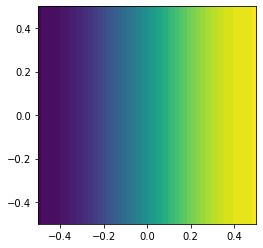

In [ ]:
plot(c)

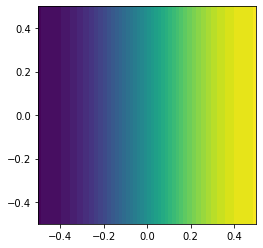

In [ ]:
V = FunctionSpace(mesh, "Lagrange", 1)
c_exa = Expression("(t+1)*sin(alpha*pi*x[0])",t = t, alpha=alpha, pi=np.pi, degree=2)
c_exact = interpolate(c_exa, V)
plot(c_exact)

In [ ]:
L2_error = np.sqrt(assemble(pow(abs(c-c_exact),2)*dx))
L2_error

7.567565492042754e-05

In [ ]:
H2_error = np.sqrt(assemble((pow(abs(c-c_exact),2) + dot(grad(c-c_exact), grad(c-c_exact)))*dx))
H2_error

Calling FFC just-in-time (JIT) compiler, this may take some time.


0.004958344021339622

In [ ]:
H1_errors

[0.022359467621646045,
 0.004982915917827839,
 0.0012381139714196308,
 6.156377392381541,
 4.979815892495903,
 5.043537536367505,
 0.7918386105469714,
 0.20523600461809466,
 0.0512889365636106]

In [ ]:
L2_errors

[0.00037093473284368305,
 8.727463352551597e-05,
 2.3065503570365772e-05,
 0.10767698923480219,
 0.09476327876857422,
 0.09540217682781195,
 0.015216895312848465,
 0.003915536465680443,
 0.0009853268522694203]

In [ ]:
H1_errors

[0.0003110162437619287, 5.065971651757262, 0.012915462754949111]

In [ ]:
L2_errors

[9.108174966908156e-06, 0.09562046346039085, 0.0002498987942449386]

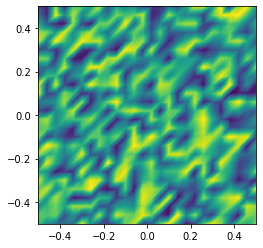

In [ ]:
"""Initial Contidion"""
import random
from dolfin import *
import numpy as np

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
        
# Model parameters
mesh_size = 25
t = 0

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        values[0] = random.uniform(-1,1)
        values[1] = 0
        
    def value_shape(self):
        return (2,)
mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5,0.5),mesh_size,mesh_size)

P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)

# Define functions
u00  = Function(ME)  # solution from previous converged step

# Split mixed functions
c00,  mu00  = split(u00)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=2)
u00.interpolate(u_init)

plot(c00)

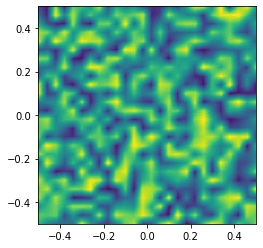

In [ ]:
mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5,0.5),mesh_size,200)
V = FunctionSpace(mesh, "Lagrange", 1)

P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)
# Define trial and test functions
du    = TrialFunction(ME)
q, v  = TestFunctions(ME)

# Define functions
u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc, dmu = split(du)
c,  mu  = split(u)
c0, mu0 = split(u0)


u.interpolate(u00)
plot(c)

In [ ]:
import random
from dolfin import *
import numpy as np

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

L2_errors = []
H1_errors = []

convergence = []

for lmbda in [1.0e-6 ,1.0e-5 ,1.0e-4,1.0e-3,1.0e-2]:
   for dt in [1.0e-06,1.0e-05,1.0e-04,1.0e-03,1.0e-02,1.0e-01,1.0]:
      for mesh_size in [25,50,100,150,200,300,400]:
          try:
              # Model parameters
              # lmbda  = 1.0e-4  # surface parameter
              # dt     = 1.0e-05  # time step
              tend = 10
              num = int(tend/dt) + 1
              time_array = np.linspace(0,tend, num)
              theta  = 1      # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson
              # mesh_size = 96
              t = 0

              # Create mesh and build function space
              # mesh = UnitSquareMesh.create(96, 96, CellType.Type.triangle)
              mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5,0.5),mesh_size,mesh_size)
              # V = FunctionSpace(mesh, "Lagrange", 1)
              P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
              ME = FunctionSpace(mesh, P1*P1)

              # Define trial and test functions
              du    = TrialFunction(ME)
              q, v  = TestFunctions(ME)

              # Define functions
              u   = Function(ME)  # current solution
              u0  = Function(ME)  # solution from previous converged step

              # Split mixed functions
              dc, dmu = split(du)
              c,  mu  = split(u)
              c0, mu0 = split(u0)

              # Create intial conditions and interpolate
              u.interpolate(u00)
              u0.interpolate(u00)

              # Compute the chemical potential df/dc
              c = variable(c)
              f    = c**4/4 - c**2/2
              dfdc = diff(f, c)

              # mu_(n+theta)
              mu_mid = (1.0-theta)*mu0 + theta*mu

              # Weak statement of the equations
              L0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx
              L1 = mu*v*dx - dfdc*v*dx - lmbda*dot(grad(c), grad(v))*dx
              F = L0 + L1

              # Output file
              file_results = XDMFFile(f"./cahn-hilliard/ch-solution_2d.xdmf")
              file_results.parameters["flush_output"] = True
              file_results.parameters["functions_share_mesh"] = True

              def save_to_file(uu, t):
                  _c, _mu = uu.split()
                  _c.rename("c", "concentration")
                  _mu.rename("mu", "chemical potential")
                  file_results.write(_c, t)
                  file_results.write(_mu, t)

              count = 0
              for t in time_array:
                  save_to_file(u,t)
                  solve(F==0, u ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                                      "relative_tolerance": 1e-6,
                                                                      #"preconditioner":"ilu",
                                                                      "convergence_criterion":"incremental",
                                                                      }})
                  u0.assign(u)
                  
                  if count > 5:
                      break
                  count +=1
                  # print(f"Time = {t}")
              save_to_file(u,t)
              print(f"Converged: eps= {lmbda}, dt= {dt}, mesh_size= {mesh_size}")
              convergence.append([lmbda,dt,mesh_size,1])
          except:
              print(f"Not Converged: eps= {lmbda}, dt= {dt}, mesh_size= {mesh_size}")
              convergence.append([lmbda,dt,mesh_size,0])

Converged: eps= 1e-06, dt= 1e-06, mesh_size= 25
Converged: eps= 1e-06, dt= 1e-06, mesh_size= 50
Converged: eps= 1e-06, dt= 1e-06, mesh_size= 100
Converged: eps= 1e-06, dt= 1e-06, mesh_size= 150
Converged: eps= 1e-06, dt= 1e-06, mesh_size= 200
Converged: eps= 1e-06, dt= 1e-06, mesh_size= 300
Converged: eps= 1e-06, dt= 1e-06, mesh_size= 400
Converged: eps= 1e-06, dt= 1e-05, mesh_size= 25
Converged: eps= 1e-06, dt= 1e-05, mesh_size= 50
Not Converged: eps= 1e-06, dt= 1e-05, mesh_size= 100
Not Converged: eps= 1e-06, dt= 1e-05, mesh_size= 150
Not Converged: eps= 1e-06, dt= 1e-05, mesh_size= 200
Not Converged: eps= 1e-06, dt= 1e-05, mesh_size= 300
Not Converged: eps= 1e-06, dt= 1e-05, mesh_size= 400
Converged: eps= 1e-06, dt= 0.0001, mesh_size= 25
Not Converged: eps= 1e-06, dt= 0.0001, mesh_size= 50
Not Converged: eps= 1e-06, dt= 0.0001, mesh_size= 100
Not Converged: eps= 1e-06, dt= 0.0001, mesh_size= 150
Not Converged: eps= 1e-06, dt= 0.0001, mesh_size= 200
Not Converged: eps= 1e-06, dt= 0.0

In [ ]:
convergence

[[1e-06, 1e-06, 25, 1],
 [1e-06, 1e-06, 50, 1],
 [1e-06, 1e-06, 100, 1],
 [1e-06, 1e-06, 150, 1],
 [1e-06, 1e-06, 200, 1],
 [1e-06, 1e-06, 300, 1],
 [1e-06, 1e-06, 400, 1],
 [1e-06, 1e-05, 25, 1],
 [1e-06, 1e-05, 50, 1],
 [1e-06, 1e-05, 100, 0],
 [1e-06, 1e-05, 150, 0],
 [1e-06, 1e-05, 200, 0],
 [1e-06, 1e-05, 300, 0],
 [1e-06, 1e-05, 400, 0],
 [1e-06, 0.0001, 25, 1],
 [1e-06, 0.0001, 50, 0],
 [1e-06, 0.0001, 100, 0],
 [1e-06, 0.0001, 150, 0],
 [1e-06, 0.0001, 200, 0],
 [1e-06, 0.0001, 300, 0],
 [1e-06, 0.0001, 400, 0],
 [1e-06, 0.001, 25, 0],
 [1e-06, 0.001, 50, 0],
 [1e-06, 0.001, 100, 0],
 [1e-06, 0.001, 150, 0],
 [1e-06, 0.001, 200, 0],
 [1e-06, 0.001, 300, 0],
 [1e-06, 0.001, 400, 0],
 [1e-06, 0.01, 25, 0],
 [1e-06, 0.01, 50, 0],
 [1e-06, 0.01, 100, 0],
 [1e-06, 0.01, 150, 0],
 [1e-06, 0.01, 200, 0],
 [1e-06, 0.01, 300, 0],
 [1e-06, 0.01, 400, 0],
 [1e-06, 0.1, 25, 0],
 [1e-06, 0.1, 50, 0],
 [1e-06, 0.1, 100, 0],
 [1e-06, 0.1, 150, 0],
 [1e-06, 0.1, 200, 0],
 [1e-06, 0.1, 300, 0],

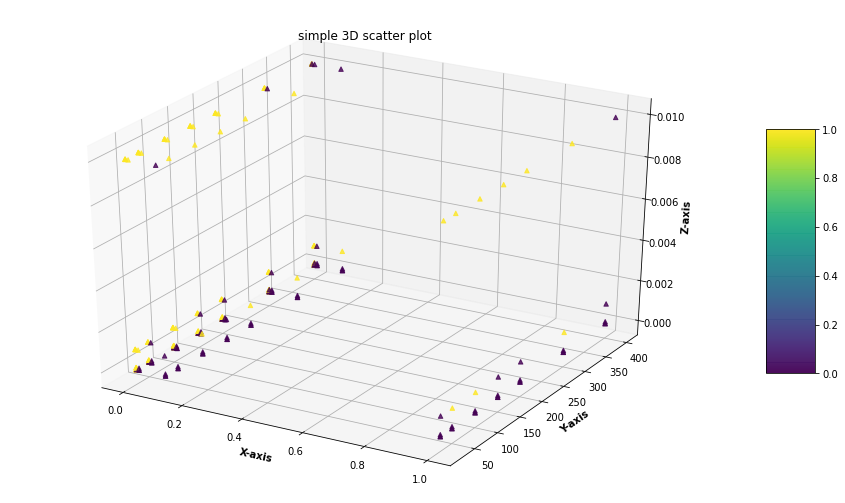

In [ ]:
import pandas as pd

df = pd.DataFrame(convergence)
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
z = list(df[0])
x = list(df[1])
y = list(df[2])
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = list(df[3]),
                    
                    marker ='^')
 
plt.title("simple 3D scatter plot")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()


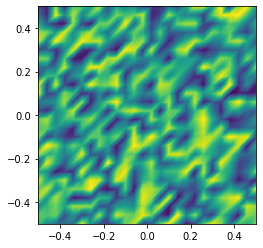

In [ ]:
"""Initial Contidion"""
import random
from dolfin import *
import numpy as np

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
        
# Model parameters
mesh_size = 25
t = 0

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        values[0] = random.uniform(-1,1) # 0.63 + 0.02*(0.5 - random.random())
        values[1] = 0
        
    def value_shape(self):
        return (2,)
mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5,0.5),mesh_size,mesh_size)

P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)

# Define functions
u00  = Function(ME)  # solution from previous converged step

# Split mixed functions
c00,  mu00  = split(u00)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=2)
u00.interpolate(u_init)

plot(c00)

In [ ]:
import random
from dolfin import *
import numpy as np

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

L2_errors = []
H1_errors = []

convergence = []
ginsburg_landaus=[[],[],[],[]]
times = [[],[],[],[]]

for dt in [1.0e-04]:
  i = 0
  for mesh_size in [25,50,80,100]:
      
      # Model parameters
      lmbda  = 1.0e-2  # surface parameter
      # dt     = 1.0e-05  # time step
      tend = 0.0025
      num = int(tend/dt) + 1
      time_array = np.linspace(0,tend, num)
      theta  = 1      # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson
      # mesh_size = 96
      t = 0

      # Create mesh and build function space
      # mesh = UnitSquareMesh.create(96, 96, CellType.Type.triangle)
      mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5,0.5),mesh_size,mesh_size)
      # V = FunctionSpace(mesh, "Lagrange", 1)
      P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
      ME = FunctionSpace(mesh, P1*P1)
      V = FunctionSpace(mesh, "Lagrange",1)

      # Define trial and test functions
      du    = TrialFunction(ME)
      q, v  = TestFunctions(ME)

      # Define functions
      u   = Function(ME)  # current solution
      u0  = Function(ME)  # solution from previous converged step

      # Split mixed functions
      dc, dmu = split(du)
      c,  mu  = split(u)
      c0, mu0 = split(u0)

      # Create intial conditions and interpolate
      u.interpolate(u00)
      u0.interpolate(u00)

      # Compute the chemical potential df/dc
      c = variable(c)
      f    = c**4/4 - c**2/2
      dfdc = diff(f, c)

      # mu_(n+theta)
      mu_mid = (1.0-theta)*mu0 + theta*mu

      # Weak statement of the equations
      L0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx
      L1 = mu*v*dx - dfdc*v*dx - lmbda*dot(grad(c), grad(v))*dx
      F = L0 + L1

      ginsburg_landau_expression = (lmbda/2*dot(grad(c),grad(c)) + f)
      # Output file
      file_results = XDMFFile(f"./cahn-hilliard/ch-solution_2d_{mesh_size}.xdmf")
      file_results.parameters["flush_output"] = True
      file_results.parameters["functions_share_mesh"] = True

      def save_gl(t,i):
          gl = assemble((lmbda/2*dot(grad(c),grad(c)) + f)*dx)
          ginsburg_landaus[i].append(gl)
          times[i].append(t)

      def save_to_file(uu,ginsburg_landau, t):
          _c, _mu = uu.split()
          _c.rename("c", "concentration")
          _mu.rename("mu", "chemical potential")
          gl = project(ginsburg_landau,V)
          gl.rename("gl","ginsburg landau")
          file_results.write(_c, t)
          file_results.write(_mu, t)
          file_results.write(gl, t)

      # save_gl(0,i)
      for t in time_array:
          save_gl(t,i)
          save_to_file(u,ginsburg_landau_expression,t)
          solve(F==0, u ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                              "relative_tolerance": 1e-6,
                                                              #"preconditioner":"ilu",
                                                              "convergence_criterion":"incremental",
                                                              }})
          u0.assign(u)
          # print(f"Time = {t}")
          
      save_to_file(u,ginsburg_landau_expression,t)
      i += 1

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


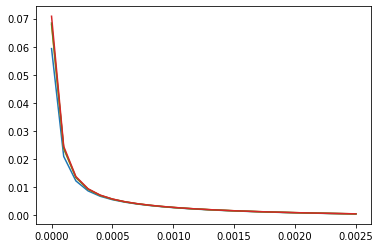

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

tend = 0.0025
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)

plt.plot(time_array, ginsburg_landaus[0])
plt.plot(time_array, ginsburg_landaus[1])
plt.plot(time_array, ginsburg_landaus[2])
plt.plot(time_array, ginsburg_landaus[3])


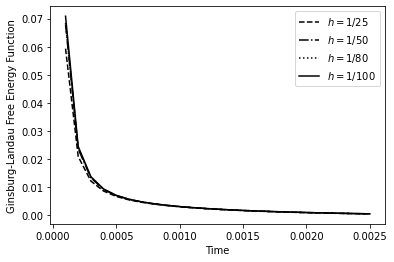

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(times[0][1:], ginsburg_landaus[0][1:], linestyle="--",label=r"$h=1/25$",c="k")
plt.plot(times[1][1:], ginsburg_landaus[1][1:], linestyle="-.",label=r"$h=1/50$",c="k")
plt.plot(times[2][1:], ginsburg_landaus[2][1:], linestyle=":",label=r"$h=1/80$",c="k")
plt.plot(times[3][1:], ginsburg_landaus[3][1:], linestyle="-",label=r"$h=1/100$",c="k")
plt.xlabel('Time')
plt.ylabel('Ginsburg-Landau Free Energy Function')
plt.legend()
plt.savefig('Ginsburg Landau Free Energy vs time.png', dpi=300)

In [ ]:
ginsburg_landau_expression = (lmbda/2*dot(grad(c),grad(c)) + f)


Calling FFC just-in-time (JIT) compiler, this may take some time.


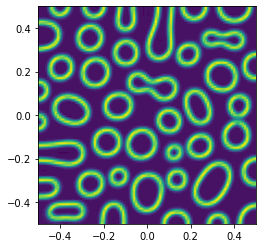

In [ ]:
plot(ginsburg_landau_expression)

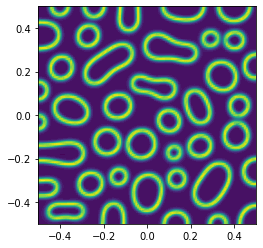

In [ ]:
plot(ginsburg_landau_expression)

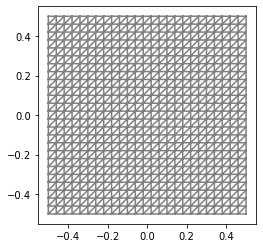

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt
mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5,0.5),25,25)
plot(mesh)
plt.savefig('mesh25.png', dpi=300)

In [ ]:
import random
from dolfin import *
import numpy as np

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

L2_errors = []
H1_errors = []

convergence = []
ginsburg_landaus=[[],[],[]]
times = [[],[],[]]
i = 0
for dt in [1.0e-03, 5.0e-04, 1.0e-04]:
  for mesh_size in [100]:

      # Model parameters
      lmbda  = 1.0e-2  # surface parameter
      # dt     = 1.0e-05  # time step
      tend = 0.025
      num = int(tend/dt) + 1
      time_array = np.linspace(0,tend, num)
      theta  = 1      # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson
      # mesh_size = 96
      t = 0

      # Create mesh and build function space
      # mesh = UnitSquareMesh.create(96, 96, CellType.Type.triangle)
      mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5,0.5),mesh_size,mesh_size)
      # V = FunctionSpace(mesh, "Lagrange", 1)
      P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
      ME = FunctionSpace(mesh, P1*P1)
      V = FunctionSpace(mesh, "Lagrange",1)

      # Define trial and test functions
      du    = TrialFunction(ME)
      q, v  = TestFunctions(ME)

      # Define functions
      u   = Function(ME)  # current solution
      u0  = Function(ME)  # solution from previous converged step

      # Split mixed functions
      dc, dmu = split(du)
      c,  mu  = split(u)
      c0, mu0 = split(u0)

      # Create intial conditions and interpolate
      u.interpolate(u00)
      u0.interpolate(u00)

      # Compute the chemical potential df/dc
      c = variable(c)
      f    = c**4/4 - c**2/2 #100*c**2*(1-c)**2
      dfdc = diff(f, c)

      # mu_(n+theta)
      mu_mid = (1.0-theta)*mu0 + theta*mu

      # Weak statement of the equations
      L0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx
      L1 = mu*v*dx - dfdc*v*dx - lmbda*dot(grad(c), grad(v))*dx
      F = L0 + L1

      ginsburg_landau_expression = (lmbda/2*dot(grad(c),grad(c)) + f)
      # Output file
      file_results = XDMFFile(f"./cahn-hilliard/ch-solution_2d_t_{dt}.xdmf")
      file_results.parameters["flush_output"] = True
      file_results.parameters["functions_share_mesh"] = True

      def save_gl(t,i):
          gl = assemble((lmbda/2*dot(grad(c),grad(c)) + f)*dx)
          ginsburg_landaus[i].append(gl)
          times[i].append(t)

      def save_to_file(uu,ginsburg_landau, t):
          _c, _mu = uu.split()
          _c.rename("c", "concentration")
          _mu.rename("mu", "chemical potential")
          gl = project(ginsburg_landau,V)
          gl.rename("gl","ginsburg landau")
          file_results.write(_c, t)
          file_results.write(_mu, t)
          file_results.write(gl, t)


      for t in time_array:
          save_gl(t,i)
          save_to_file(u,ginsburg_landau_expression,t)
          solve(F==0, u ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                              "relative_tolerance": 1e-6,
                                                              #"preconditioner":"ilu",
                                                              "convergence_criterion":"incremental",
                                                              }})
          u0.assign(u)
          # print(f"Time = {t}")
      save_to_file(u,ginsburg_landau_expression,t)
  i += 1

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


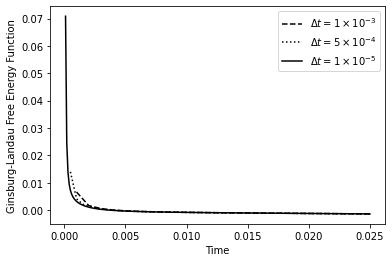

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(times[0][1:], ginsburg_landaus[0][1:], linestyle="--",label=r"$\Delta t=1 \times 10^{-3}$",c="k")
plt.plot(times[1][1:], ginsburg_landaus[1][1:], linestyle=":",label=r"$\Delta t=5 \times 10^{-4}$",c="k")
plt.plot(times[2][1:], ginsburg_landaus[2][1:], linestyle="-",label=r"$\Delta t=1 \times 10^{-5}$",c="k")
plt.xlabel('Time')
plt.ylabel('Ginsburg-Landau Free Energy Function')
plt.legend()
plt.savefig('Ginsburg Landau Free Energy vs time(dt).png', dpi=300)


In [ ]:
dt = 1.0e-03
tend = 0.0025
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
time_array
# plt.plot(time_array, ginsburg_landaus[0])

array([0.     , 0.00125, 0.0025 ])

## CH BELL element initial condition

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


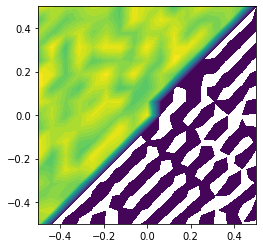

In [ ]:
"""Initial Contidion"""
import random
from dolfin import *
import numpy as np

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
        
# Model parameters
mesh_size = 16
t = 0

mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5,0.5),mesh_size,mesh_size)

P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)

# Define functions
u00  = Function(ME)  # solution from previous converged step

# Split mixed functions
c00,  mu00  = split(u00)

initial_c = np.array([0.70565461, 0.69605542, 0.55325392, 0.67414701, 0.66313631,
       0.56978194, 0.64140415, 0.5548059 , 0.64650645, 0.69922558,
       0.63886581, 0.68049584, 0.57427854, 0.72586912, 0.56102945,
       0.71088129, 0.56297392, 0.5983581 , 0.62910332, 0.70338795,
       0.54431708, 0.5564908 , 0.72399641, 0.58976473, 0.6350587 ,
       0.61804565, 0.60668091, 0.60398054, 0.66700983, 0.71024665,
       0.72802611, 0.58241047, 0.66842546, 0.66525021, 0.53023   ,
       0.61138959, 0.68039997, 0.6856168 , 0.62891698, 0.68212006,
       0.65807028, 0.67015248, 0.72882792, 0.62167185, 0.70098732,
       0.63548384, 0.55000839, 0.55277292, 0.71244824, 0.64309221,
       0.59092216, 0.72375624, 0.60887157, 0.59937045, 0.54449007,
       0.67926113, 0.69598675, 0.63754629, 0.55308732, 0.63179142,
       0.55266711, 0.5899147 , 0.69415171, 0.63401416, 0.65530123,
       0.64487251, 0.65016239, 0.62436834, 0.55371038, 0.57610074,
       0.70884566, 0.57821168, 0.60316912, 0.70528923, 0.65711071,
       0.65877406, 0.60863165, 0.54705707, 0.63174724, 0.72118712,
       0.55147256, 0.71673474, 0.71832986, 0.56448598, 0.57822244,
       0.72151163, 0.71135804, 0.54846661, 0.67368868, 0.71631484,
       0.56309018, 0.56284383, 0.66500556, 0.60863528, 0.59031274,
       0.60183783, 0.545805  , 0.55287738, 0.65840896, 0.60571287,
       0.58491157, 0.56727568, 0.71789657, 0.68641938, 0.57979213,
       0.59626169, 0.64401929, 0.56469265, 0.64627474, 0.58020246,
       0.71558489, 0.57965255, 0.64739039, 0.65110235, 0.56848278,
       0.6387489 , 0.64665989, 0.65229906, 0.66939976, 0.54252353,
       0.72730029, 0.59446088, 0.60028007, 0.53728727, 0.58777727,
       0.58161241, 0.64034665, 0.55677998, 0.70799761, 0.67004245,
       0.53352937, 0.71704445, 0.71698285, 0.69678689, 0.6457385 ,
       0.58231823, 0.649128  , 0.60628039, 0.64545056, 0.53678257,
       0.60123523, 0.69721513, 0.65977689, 0.66724277, 0.60435367,
       0.58803487, 0.5993089 , 0.61917684, 0.72515004, 0.70093032,
       0.63211444, 0.53352891, 0.66555981, 0.71440643, 0.63300981,
       0.54630106, 0.5761    , 0.58945996, 0.53437898, 0.67105016,
       0.68968515, 0.61325816, 0.65097061, 0.65387586, 0.7039852 ,
       0.68885166, 0.70052201, 0.54136283, 0.53229778, 0.5620364 ,
       0.7178473 , 0.64489153, 0.64394424, 0.61540316, 0.59301879,
       0.57314523, 0.70184387, 0.60423043, 0.62677782, 0.5940049 ,
       0.68972906, 0.72765452, 0.63720558, 0.70347191, 0.56334881,
       0.62863357, 0.66159701, 0.72923255, 0.57145728, 0.57564817,
       0.63169627, 0.71900164, 0.65145827, 0.67626072, 0.70408054,
       0.6525548 , 0.56973805, 0.67228083, 0.56006483, 0.63468947,
       0.55696984, 0.67841125, 0.71137989, 0.60715954, 0.57505279,
       0.66529188, 0.56859416, 0.70906857, 0.64180516, 0.60480351,
       0.57989666, 0.7034729 , 0.59324539, 0.61198613, 0.69083634,
       0.69893519, 0.54887368, 0.56839644, 0.55742644, 0.72860862,
       0.58373857, 0.55041695, 0.5874927 , 0.65842437, 0.53963626,
       0.59208366, 0.54211636, 0.64780368, 0.64721036, 0.66916703,
       0.72596671, 0.69666198, 0.70993659, 0.61953489, 0.68971013,
       0.69821849, 0.58239428, 0.71310211, 0.64374539, 0.59897912,
       0.65983136, 0.59911938, 0.61210631, 0.64693096, 0.6043393 ,
       0.57784428, 0.65751187, 0.69261586, 0.71402576, 0.71622473,
       0.70471789, 0.64497874, 0.72012334, 0.60809635, 0.60405519,
       0.64317258, 0.60144633, 0.72695783, 0.63478484, 0.53685711,
       0.57175871, 0.71434003, 0.57702319, 0.62245054, 0.61261837,
       0.58192069, 0.58423742, 0.61766989, 0.61982047, 0.6083074 ,
       0.5658168 , 0.71997569, 0.62351579, 0.69872352, 0.67320144,
       0.61234347, 0.58222506, 0.63271947, 0.5735681 , 0.7206793 ,
       0.67744761, 0.65130049, 0.64485682, 0.70513009, 0.66747232,
       0.6752047 , 0.61964935, 0.63103848, 0.71342967])

initial_mu = np.zeros(initial_c.shape[0])
initial_c.shape[0]
u00.vector()[:] = np.concatenate([initial_c,initial_mu])
plot(c00)

array([0.70565461, 0.69605542, 0.55325392, 0.67414701, 0.66313631,
       0.56978194, 0.64140415, 0.5548059 , 0.64650645, 0.69922558,
       0.63886581, 0.68049584, 0.57427854, 0.72586912, 0.56102945,
       0.71088129, 0.56297392, 0.5983581 , 0.62910332, 0.70338795,
       0.54431708, 0.5564908 , 0.72399641, 0.58976473, 0.6350587 ,
       0.61804565, 0.60668091, 0.60398054, 0.66700983, 0.71024665,
       0.72802611, 0.58241047, 0.66842546, 0.66525021, 0.53023   ,
       0.61138959, 0.68039997, 0.6856168 , 0.62891698, 0.68212006,
       0.65807028, 0.67015248, 0.72882792, 0.62167185, 0.70098732,
       0.63548384, 0.55000839, 0.55277292, 0.71244824, 0.64309221,
       0.59092216, 0.72375624, 0.60887157, 0.59937045, 0.54449007,
       0.67926113, 0.69598675, 0.63754629, 0.55308732, 0.63179142,
       0.55266711, 0.5899147 , 0.69415171, 0.63401416, 0.65530123,
       0.64487251, 0.65016239, 0.62436834, 0.55371038, 0.57610074,
       0.70884566, 0.57821168, 0.60316912, 0.70528923, 0.65711

## Comparison of Lagrange and Bell Elements

In [ ]:
import time
import random
from dolfin import *

start = time.time()

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):
        values[0] = 0.63 + 0.02*(0.5 - random.random())
        values[1] = 0.0
    def value_shape(self):
        return (2,)

# Class for interfacing with the Newton solver
class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

# Model parameters
lmbda  = 1.0e-02  # surface parameter
dt     = 5.0e-06  # time step
theta  = 0.5      # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Create mesh and build function space
mesh = UnitSquareMesh.create(96, 96, CellType.Type.triangle)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)
# Define trial and test functions
du    = TrialFunction(ME)
q, v  = TestFunctions(ME)

# Define functions
u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dc, dmu = split(du)
c,  mu  = split(u)
c0, mu0 = split(u0)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
u.interpolate(u_init)
u0.interpolate(u_init)

# Compute the chemical potential df/dc
c = variable(c)
f    = 100*c**2*(1-c)**2
dfdc = diff(f, c)

# mu_(n+theta)
mu_mid = (1.0-theta)*mu0 + theta*mu

# Weak statement of the equations
L0 = c*q*dx - c0*q*dx + dt*dot(grad(mu_mid), grad(q))*dx
L1 = mu*v*dx - dfdc*v*dx - lmbda*dot(grad(c), grad(v))*dx
L = L0 + L1

# Compute directional derivative about u in the direction of du (Jacobian)
a = derivative(L, u, du)

# Create nonlinear problem and Newton solver
problem = CahnHilliardEquation(a, L)
solver = NewtonSolver()
solver.parameters["linear_solver"] = "lu"
solver.parameters["convergence_criterion"] = "incremental"
solver.parameters["relative_tolerance"] = 1e-6

# Output file
file_results = XDMFFile("./cahn-hilliard/ch-solution_2d.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

def save_to_file(uu, t):
    _c, _mu = uu.split()
    _c.rename("c", "concentration")
    _mu.rename("mu", "chemical potential")
    file_results.write(_c, t)
    file_results.write(_mu, t)

# Step in time
t = 0.0
T = 0.0025
# save_to_file(u,t)
while (t < T):
    t += dt
    u0.vector()[:] = u.vector()
    solver.solve(problem, u.vector())
    # save_to_file(u,t)

end = time.time()
print(end - start)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
305.0759913921356


## Install Firedrake

In [ ]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2021-09-01 17:41:36--  https://fem-on-colab.github.io/releases/firedrake-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1892 (1.8K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   1.85K  --.-KB/s    in 0s      

2021-09-01 17:41:36 (25.9 MB/s) - ‘/tmp/firedrake-install.sh’ saved [1892/1892]

+ PYBIND11_INSTALL_SCRIPT_PATH=https://fem-on-colab.github.io/releases/pybind11-install.sh
+ [[ https://fem-on-colab.github.io/releases/pybind11-install.sh == http* ]]
+ wget https://fem-on-colab.github.io/releases/pybind11-install.sh -O /tmp/pybind11-install.sh
--2021-09-01 17:41:36--  https://fem-on-colab.github.io/releases/pybind11-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.

## Firedrake Solution

In [ ]:
from firedrake import *
import numpy
start = time.time()

mesh = UnitSquareMesh(16, 16)
# Set parameters
lmbda = 1e-2
delta_t = 5e-6
theta = 0.5
M=1
beta = 250
# Pick function space
V = FunctionSpace(mesh, "Bell", 5)
c = Function(V)
c0 = Function(V)

# Initial conditions
c0.vector()[::6] = 0.63 + 0.2*(0.5 - numpy.random.random(c0.vector().local_size() // 6))
c.assign(c0)

c_theta = theta*c + (1 - theta)*c0
dfdc = 200*( c_theta *(1 - c_theta )**2 - c_theta **2*(1 - c_theta ))
n = FacetNormal(mesh)
h = CellSize(mesh)

# Nonlinear residual
v = TestFunction(V)
F = (inner(c - c0, v)*dx + \
    delta_t*(inner(M*grad(dfdc), grad(v))*dx +
            inner(M*lmbda*div(grad(c_theta)), div(grad(v)))*dx - 
            inner(M*lmbda*div(grad(c_theta)), dot(grad(v), n))*ds - 
            inner(M*lmbda*dot(grad(c_theta), n), div(grad(v)))*ds + 
            inner((beta/h)*M*lmbda*dot(grad(c_theta), n), dot(grad(v), n))*ds))

problem = NonlinearVariationalProblem(F, c)
solver = NonlinearVariationalSolver(problem, solver_parameters={"ksp_type": "preonly","pc_type": "lu"})
file = File("cahn_hilliard/cahn_hilliard_bell.pvd")

t = 0
T = 0.0025 
# file.write(c,time=t)
while t < T:
    solver.solve()
    # file.write(c,time=t)
    c0.assign(c)
    t += delta_t

end = time.time()
print(end - start)

150.3907573223114
